<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/DynNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings - Paths - Clone github rep

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# clone github
!git clone https://github.com/katduecker/dnn_osci

# enter folder
%cd dnn_osci
%cd aet_pytorch/


load_NN = False       # load pre-trained NN?
save_NN = False       # save trained NN?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'dnn_osci' already exists and is not an empty directory.
/content/dnn_osci
/content/dnn_osci/aet_pytorch


In [2]:
# import packages

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# colours for plot
col = mcolors.TABLEAU_COLORS

from itertools import combinations


plt.rcParams["figure.figsize"] = (18,3)

font = {'weight' : 'normal',
        'size'   : 14,
        'family' : 'sans-serif'}
plt.rc('font',**font)

In [3]:
import aet_net            # 1-layer architecture
import aet_net_2lay       # 2-layer architecture


## Helper functions

In [31]:
# sigmoid activation with option to stretch and shift
def sigmoid(z,sig_param):

    _slope,_bias = sig_param

    return 1.0/(1.0+np.exp(-_slope*(z+_bias)))

In [36]:
# forward dynamics/discretization, euler integration
def euler_dyn(Z,t_,params_,alpha_params_,sig_param):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S,h_start,R_start,t_start = params_


    # alpha frequency & amplitude
    _af,_aa,_ap = alpha_params_


    # initialize empty matrices
    dt = np.diff(t_)[0]
    dh1dt = (np.zeros((len(t_)+1,)))
    dR1dt = (np.zeros((len(t_)+1,)))
    dR1dt[0] = R_start;
    dZdt = (np.zeros((len(t_)+1,)))

    # alpha inhibition
    alpha_inh1 = _aa*np.sin(2*np.pi*_af*t_+_ap)+_aa

    boxcar = np.zeros(len(t_))
    boxcar[t_start:] = 1

    for _it,t in enumerate(t_):

        # pre-activation
        dZdt[_it+1] = (Z*boxcar[_it] + dh1dt[_it] - dR1dt[_it] - alpha_inh1[_it])/S

        # dynamics hidden layer1
        dh1dt[_it+1] = dh1dt[_it] + dt/tau_h * (-dh1dt[_it] + sigmoid(dZdt[_it+1],sig_param))

        # adaptation term 1
        dR1dt[_it+1] = dR1dt[_it] + dt/tau_R * (-dR1dt[_it] + c*dh1dt[_it+1])



    return dZdt, dh1dt, dR1dt

In [4]:
# create stimuli

x_train, y_train = aet_net_2lay.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

# Train networks

In [5]:
# one layer network

nn_dim_ = [28,64,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 0.1           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 100

beta_ = 0
p_ = 0
kl_reg_ = [0,0.01]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param = [2, -2.5, False] # sigmoid slope and shift in x direction

ortho_lmbda = 0 # orthogonality penalty

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda

# initialize model and weights
model1 = aet_net.net(params,lossfun)
model1 = aet_net.init_params(model1,weight_init='uni')
optimizer = torch.optim.SGD(model1.parameters(),lr=eta_)

model1.to(DEVICE)
loss_hist1 = model1.train(optimizer,noise=False,print_loss=False)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [6]:
# hidden layer activations

Z1,H1,O1 = model1.forw_conv(x_train)


In [7]:
nn_dim_ = [28,64,32,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 1e-3           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 100

beta_ = 0
p_ = .02              # has to be != 0 even if not used
kl_reg_ = [beta_,p_,1]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param =[[2, -2.5, False],[2, -2.5, False]] # sigmoid slope and shift in x direction

ortho_lmbda = 0
ortho_layer = 2

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda,ortho_layer

# initialize model and weights
model2 = aet_net_2lay.net(params,lossfun)
model2 = aet_net_2lay.init_params(model2,weight_init='uni')

optimizer = torch.optim.Adam(model2.parameters(),lr=eta_)

model2.to(DEVICE)
loss_hist2 = model2.train(optimizer,noise=False,print_loss=False)

In [8]:
# hidden layer activations

Z21,H21,H22,O2 = model2.forw_conv(x_train)

Z22 = model2.fc1(H21)

In [9]:
idx = np.array((0,4,8))
label = ['A','E','T']

<ipython-input-10-277f9d575084>:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


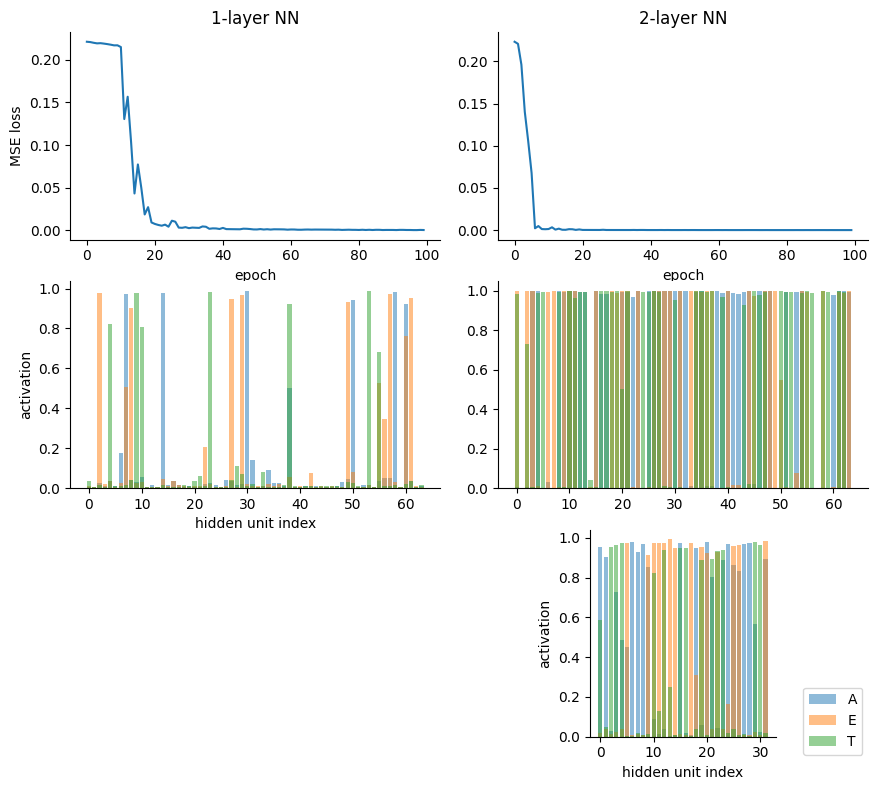

In [10]:
# plot

font = {'weight' : 'normal',
        'size'   : 10,
        'family' : 'sans-serif'}
plt.rc('font',**font)


plt.rcParams["figure.figsize"] = (8.9,8)


fig = plt.figure(layout="constrained")
gs0 = fig.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(3, 1)
gs01 = gs0[1].subgridspec(3, 1)

for a in range(gs00.nrows):
    ax = fig.add_subplot(gs00[a])
    ax.spines[['right', 'top']].set_visible(False)
    if a == 0:
      ax.set_ylabel('MSE loss')
      ax.set_xlabel('epoch')
      ax.plot(np.arange(num_epo_),loss_hist1.detach().cpu())
      ax.set_title('1-layer NN')
    if a == 1:
      ax.set_ylabel('activation')
      ax.set_xlabel('hidden unit index')
      for i,ii in enumerate(idx):
        ax.bar(np.arange(model1.fc1.in_features),H1[ii].detach().cpu().numpy(),alpha=0.5)

    if a == 2:

      ax.axis('off')


for a in range(gs01.nrows):
    ax = fig.add_subplot(gs01[a])
    ax.spines[['right', 'top']].set_visible(False)
    if a == 0:
      ax.set_xlabel('epoch')
      ax.plot(np.arange(num_epo_),loss_hist2.detach().cpu())
      ax.set_title('2-layer NN')

    if a == 1:
      for i,ii in enumerate(idx):
        ax.bar(np.arange(model2.fc1.in_features),H21[ii].detach().cpu().numpy(),alpha=0.5)


    if a == 2:
      ax.set_ylabel('activation')
      ax.set_xlabel('hidden unit index')
      for i,ii in enumerate(idx):
        ax.bar(np.arange(model2.fc2.in_features),H22[ii].detach().cpu().numpy(),alpha=0.5)

      ax.set_box_aspect(1/0.9)
      ax.legend(label,loc='lower right',bbox_to_anchor=(1.5, -0.12),ncol=1,frameon=True)



fig.tight_layout()

# Explore dynamics single neuron

Dynamics in each hidden unit

$\tau_H \frac{dH_j}{dt} = -H_j + \sigma (\frac{Z_j - R_j + \alpha (t) + H_j}{S})$


Relaxation dynamics

$\tau_R = \frac{dR_j}{dt} = -R_j + c \cdot H_j$

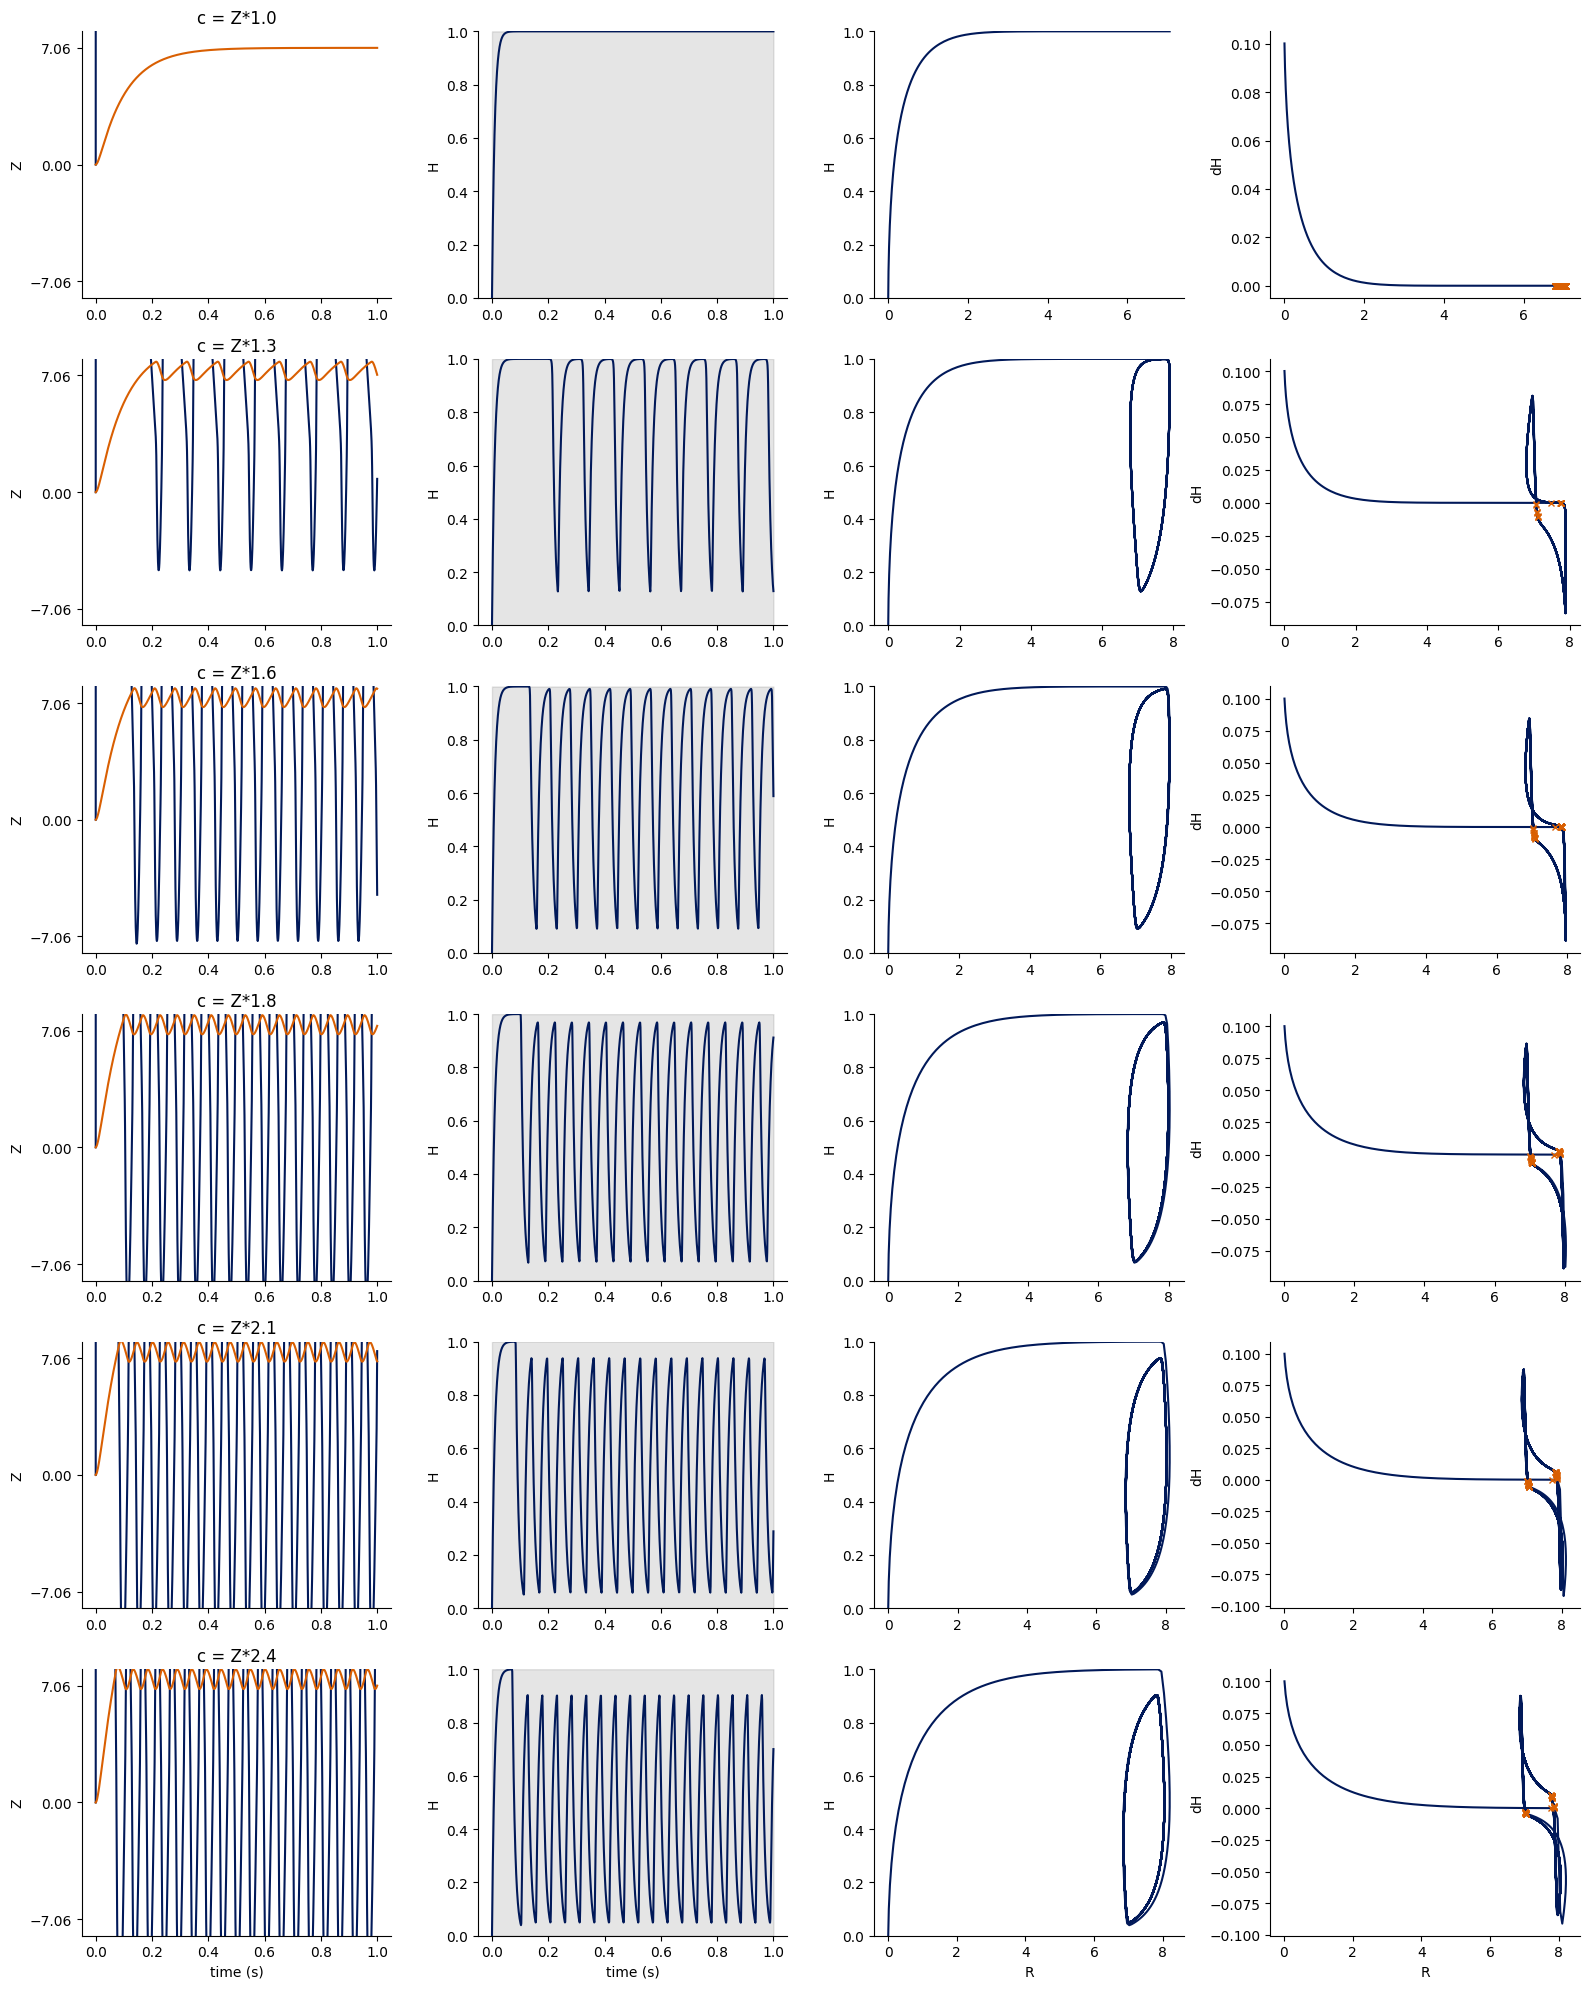

In [71]:
Z = torch.max(Z21).detach().cpu().item()

tau_h = 0.01
tau_R = 0.1
S = .05
h_start = 0
R_start = 0


tryC = np.arange(Z,2.5*Z,2)
plt.rcParams["figure.figsize"] = (16,20)

fig, axs = plt.subplots(tryC.shape[0],4)

t_start = 0
t = 0

for i,c in enumerate(tryC):

  params = [tau_h,tau_R,c,S,h_start,R_start,t_start]

  afreq = 10
  aamp = 0
  aph = 0

  alpha_params = [afreq,aamp,aph]

  timevec = np.linspace(0,1,1000)

  Zt,Ht,Rt = euler_dyn(Z,timevec,params,alpha_params,model1.sig_param[0:-1])

  # Input Z (inside sigmoid)
  axs[i,0].plot(timevec[t:],Zt[t:-1],color = np.array((1,25,89))/255,linewidth=1.5)
  axs[i,0].plot(timevec[t:],Rt[t:-1],color = np.array((217,95,2))/255,linewidth=1.5)
  axs[i,0].set_yticks((-Z,0,Z))
  axs[i,0].set_ylim((-Z-1,Z+1))
  axs[i,0].set_ylabel('Z')
  axs[i,0].spines[['right', 'top']].set_visible(False)
  axs[i,0].set_title('c = Z*'+str(round(c/Z,1)))

  if i == tryC.shape[0]-1:
    axs[i,0].set_xlabel('time (s)')
    axs[i,1].set_xlabel('time (s)')
    axs[i,2].set_xlabel('R')
    axs[i,3].set_xlabel('R')


  axs[i,1].plot(timevec[t:],Ht[t:-1],color = np.array((1,25,89))/255,linewidth=1.5)

  if aamp:
    axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(sigmoid(Z,model1.sig_param[0:-1]),timevec[t:].shape[0]), alpha=0.1, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')
  axs[i,1].set_ylim(0,1)
  axs[i,1].spines[['right', 'top']].set_visible(False)

  axs[i,2].plot(Rt[t:],Ht[t:],color = np.array((1,25,89))/255,linewidth=1.5)
  axs[i,2].set_ylim(0,1)

  axs[i,2].set_ylabel('H')
  axs[i,2].spines[['right', 'top']].set_visible(False)

  dH = np.diff(Ht)

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(Rt[t+1:],dH,color = np.array((1,25,89))/255,linewidth=1.5)
  axs[i,3].plot(Rt[(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'x',color = np.array((217,95,2))/255,markersize=5)

  axs[i,3].set_ylabel('dH')
  axs[i,3].spines[['right', 'top']].set_visible(False)

fig.tight_layout()

$c = 1.5 \cdot Z$ to $c = 2 \cdot Z$ look reasonable
